# Home Credit Default Risk (XGB Tuning)

In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
!jt -l
!jt -t onedork -ofs 10 -dfs 9 -nfs 11 -tfs 11
jtplot.style(theme = 'onedork', fscale = 1.4 , context = 'notebook', ticks = True, 
             grid = False)

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn import linear_model, metrics
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats as sts
import xgboost as xgb
import re
import seaborn as sns
import gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Python\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Prepare dataset

In [3]:
data = pd.read_csv('Home Credit data.csv')
target = pd.read_csv('Home Credit target.csv')
ID = pd.read_csv('Home Credit target_ID.csv')

In [4]:
data.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,...,SUCCESS_COEFFICIENT,ALL_AREA,BUILD_COEFFICIENT,SOCIAL_CIRCLE,ANNUITY_COEFFICIENT,ANNUITY_LENGTH,PER_FAM_MEMBER_INCOME,PURE_FAM_MEMBER_INCOME,DIFF_PAYMENTS,LATE_PAYMENT_ALL
0,100002,Cash loans,N,Y,1,1,0,1,1,0,...,21.403658,0.0668,0.606944,4.0,0.121978,16.461103,202500.0,177799.50,20.264706,41.264706
1,100003,Cash loans,N,N,1,1,0,1,1,0,...,16.104980,0.1554,0.786799,1.0,0.132217,36.234085,135000.0,117150.75,7.105263,7.105263
2,100004,Revolving loans,Y,Y,1,1,1,1,1,0,...,3.544051,0.1423,0.744544,0.0,0.100000,20.000000,67500.0,60750.00,7.666667,7.666667
3,100006,Cash loans,N,Y,1,1,0,1,0,0,...,7.103394,0.1423,0.744544,2.0,0.219900,10.532818,67500.0,52656.75,19.666667,19.666667
4,100007,Cash loans,N,Y,1,1,0,1,0,0,...,6.095725,0.1423,0.744544,0.0,0.179963,23.461618,121500.0,99634.50,3.465556,3.465556


In [5]:
#Итоговые признаки
numeric_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                    'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 
                    'COMMONAREA_MEDI', 'ENTRANCES_MEDI', 'LANDAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
                    'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_YEAR']


categorial_features = ['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
                       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE',
                       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


binary_features = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL',
                   'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
                   'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                   'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                   'LIVE_CITY_NOT_WORK_CITY', 'EMERGENCYSTATE_MODE']


bureau_features = ['CREDIT_VALUES', 'CREDIT_ACTIVE', 'OVERDUE_MAX', 'OVERDUE_MEAN',
                   'OVERDUE_MIN', 'ENDDATE_SUM', 'ENDDATE_MEAN', 'PROLONG_MAX',
                   'PROLONG_MIN', 'PROLONG_MEAN', 'LIMIT_SUM', 'LIMIT_MEAN',
                   'ANNUITY_SUM', 'ANNUITY_MEAN']


bureau_balance_features = ['CLOSED_CREDIT', 'NO_DPD_CREDIT', 'DPD_CREDIT', 'MONTHS_BALANCE_MIN',
                           'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_MEAN']


prev_features = ['AMT_ANNUITY_PREV', 'AMT_CREDIT_PREV', 'AMT_DOWN_PAYMENT_PREV',
                 'RATE_DOWN_PAYMENT_PREV', 'DAYS_DECISION_PREV', 'SELLERPLACE_AREA_PREV',
                 'CNT_PAYMENT_PREV', 'DAYS_FIRST_DRAWING_PREV']


pos_cash_features = ['MONTHS_BALANCE_POS', 'CNT_INSTALMENT_POS', 'CNT_INSTALMENT_FUTURE_POS', 
                     'SK_DPD_POS', 'SK_DPD_DEF_POS']


ip_features = ['DAYS_INSTALMENT_IP', 'DAYS_ENTRY_PAYMENT_IP', 'AMT_INSTALMENT_IP']


engineering_features = ['EXT_SOURCE', 'CREDIT_COEFFICIENT', 'SUCCESS_COEFFICIENT',
                        'ALL_AREA', 'BUILD_COEFFICIENT', 'SOCIAL_CIRCLE', 'ANNUITY_COEFFICIENT',
                        'ANNUITY_LENGTH', 'PER_FAM_MEMBER_INCOME', 'PURE_FAM_MEMBER_INCOME',
                        'DIFF_PAYMENTS', 'LATE_PAYMENT_ALL']

In [6]:
#OneHotEncoder
data = pd.get_dummies(data[numeric_features + categorial_features + binary_features + \
                           bureau_features + bureau_balance_features + prev_features + \
                           pos_cash_features + ip_features + engineering_features])

#Итоговые признаки
features = data.columns
data.shape

#float32
data[data.columns[data.dtypes == 'float64']] = \
                                         data[data.columns[data.dtypes == 'float64']].astype('float32')

#Разделим выборку на обучающую и тестовую
data_train = data.iloc[:100000]
data_test = data.iloc[100000:]

#Del
del data
gc.collect()

25

# Tune model

 - Подбор оптимальных параметров осуществим с помощью поиска по сетке GridSearchCV

 - В качестве стратегии кросс-валидации используем StratifiedKFold на 3 фолда

In [7]:
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [8]:
#Разделим выборку на обучение и тест
x_train, x_test, y_train, y_test = train_test_split(data_train, target, 
                                                    test_size = 0.3, random_state = 42)

# Tune XGB

In [9]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42)

params_grid = {
               'max_depth' : [3, 4, 5, 6, 7, 8, 9]
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(x_train, y_train)
print grid_cv.best_params_
print 'ROC_AUC on CV:', grid_cv.best_score_

D:\Python\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Python\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'max_depth': 5}
ROC_AUC on CV: 0.759851637590002


In [10]:
xgb_model = xgb.XGBClassifier(max_depth = 5, objective = 'binary:logistic', 
                              random_state = 42)

params_grid = {
               'min_child_weight' : np.arange(1, 6, 1)
}

grid_cv = GridSearchCV(xgb_model, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(x_train, y_train)
print grid_cv.best_params_
print 'ROC_AUC on CV:', grid_cv.best_score_

{'min_child_weight': 4}
ROC_AUC on CV: 0.7601467461881403


In [11]:
xgb_model = xgb.XGBClassifier(max_depth = 5, min_child_weight = 4,
                              objective = 'binary:logistic', random_state = 42)

params_grid = {
               'subsample' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'colsample_bytree' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_cv = RandomizedSearchCV(xgb_model, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(x_train, y_train)
print grid_cv.best_params_
print 'ROC_AUC on CV:', grid_cv.best_score_

{'subsample': 0.8, 'colsample_bytree': 0.3}
ROC_AUC on CV: 0.7603735418718397


In [12]:
xgb_model = xgb.XGBClassifier(max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3, 
                              objective = 'binary:logistic', random_state = 42)


params_grid = {
               'reg_alpha' : np.arange(0, 1, 0.1)
}

grid_cv = RandomizedSearchCV(xgb_model, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(x_train, y_train)
print grid_cv.best_params_
print 'ROC_AUC on CV:', grid_cv.best_score_

{'reg_alpha': 0.9}
ROC_AUC on CV: 0.761446199606279


In [13]:
xgb_model = xgb.XGBClassifier(max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3, 
                              objective = 'binary:logistic', random_state = 42)


params_grid = {
               'reg_alpha' : np.arange(1, 1.4, 0.05)
}

grid_cv = RandomizedSearchCV(xgb_model, params_grid, cv = kf, scoring = 'roc_auc')
grid_cv.fit(x_train, y_train)
print grid_cv.best_params_
print 'ROC_AUC on CV:', grid_cv.best_score_

D:\Python\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
D:\Python\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Python\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'reg_alpha': 1.2500000000000002}
ROC_AUC on CV: 0.7618326272469547


Уменьшим learning_rate и подберем оптимальное количество деревьев по отложенной выборке

D:\Python\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Python\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC_AUC on train data 0.8805748897605137
ROC_AUC on test data: 0.773990432733606


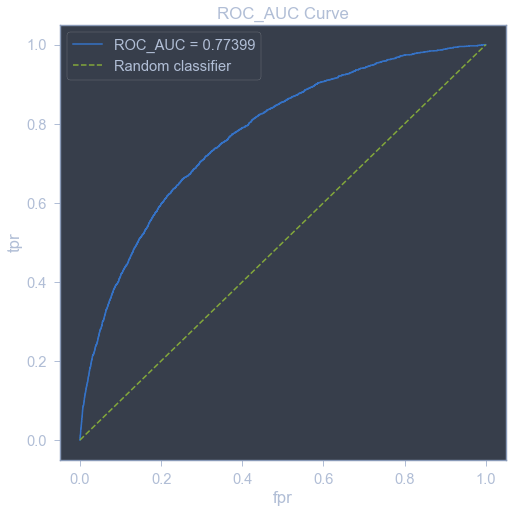

In [14]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.02, n_estimators = 1000,
                              max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3,
                              objective = 'binary:logistic', reg_alpha = 1.25,
                              random_state = 42)
#fit
xgb_model.fit(x_train, y_train)
predict = xgb_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, predict)

#Построим ROC_AUC кривую по отложенной выборке
print 'ROC_AUC on train data', metrics.roc_auc_score(y_train, xgb_model.predict_proba(x_train)[:, 1])
print 'ROC_AUC on test data:', metrics.roc_auc_score(y_test, predict)
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC_AUC = ' + str(round(metrics.roc_auc_score(y_test, predict), 6)))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC_AUC Curve')
plt.legend()
plt.show()

ROC_AUC on train data 0.9114453082615482
ROC_AUC on test data: 0.7740379876091629


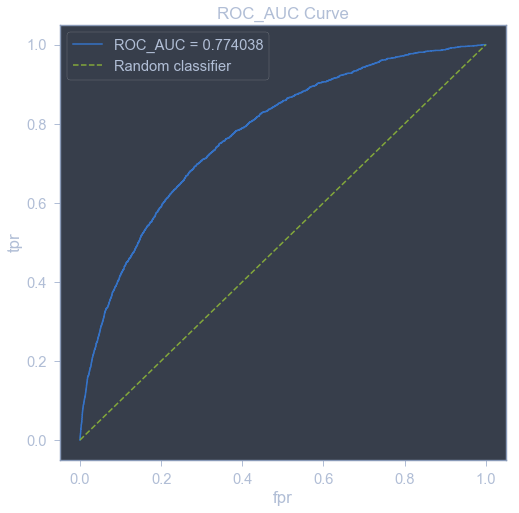

In [15]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.02, n_estimators = 1500,
                              max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3,
                              objective = 'binary:logistic', reg_alpha = 1.25,
                              random_state = 42)
#fit
xgb_model.fit(x_train, y_train)
predict = xgb_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, predict)

#Построим ROC_AUC кривую по отложенной выборке
print 'ROC_AUC on train data', metrics.roc_auc_score(y_train, xgb_model.predict_proba(x_train)[:, 1])
print 'ROC_AUC on test data:', metrics.roc_auc_score(y_test, predict)
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC_AUC = ' + str(round(metrics.roc_auc_score(y_test, predict), 6)))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC_AUC Curve')
plt.legend()
plt.show()

ROC_AUC on train data 0.9346178513245688
ROC_AUC on test data: 0.773227228018348


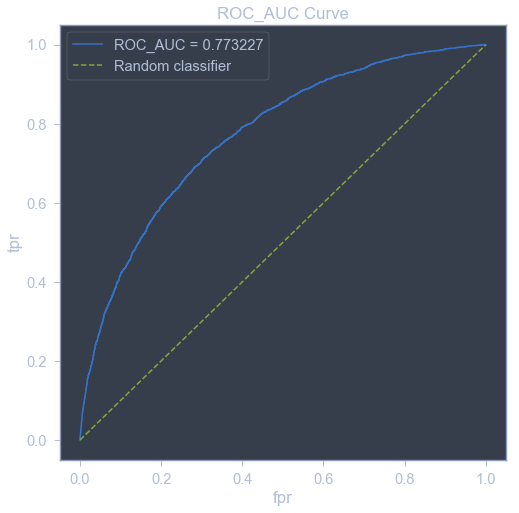

In [16]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.02, n_estimators = 2000,
                              max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3,
                              objective = 'binary:logistic', reg_alpha = 1.25,
                              random_state = 42)
#fit
xgb_model.fit(x_train, y_train)
predict = xgb_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, predict)

#Построим ROC_AUC кривую по отложенной выборке
print 'ROC_AUC on train data', metrics.roc_auc_score(y_train, xgb_model.predict_proba(x_train)[:, 1])
print 'ROC_AUC on test data:', metrics.roc_auc_score(y_test, predict)
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC_AUC = ' + str(round(metrics.roc_auc_score(y_test, predict), 6)))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC_AUC Curve')
plt.legend()
plt.show()

 - При большем количестве деревьев начинается переобучение 
 - Остановимся на 1500 деревьях

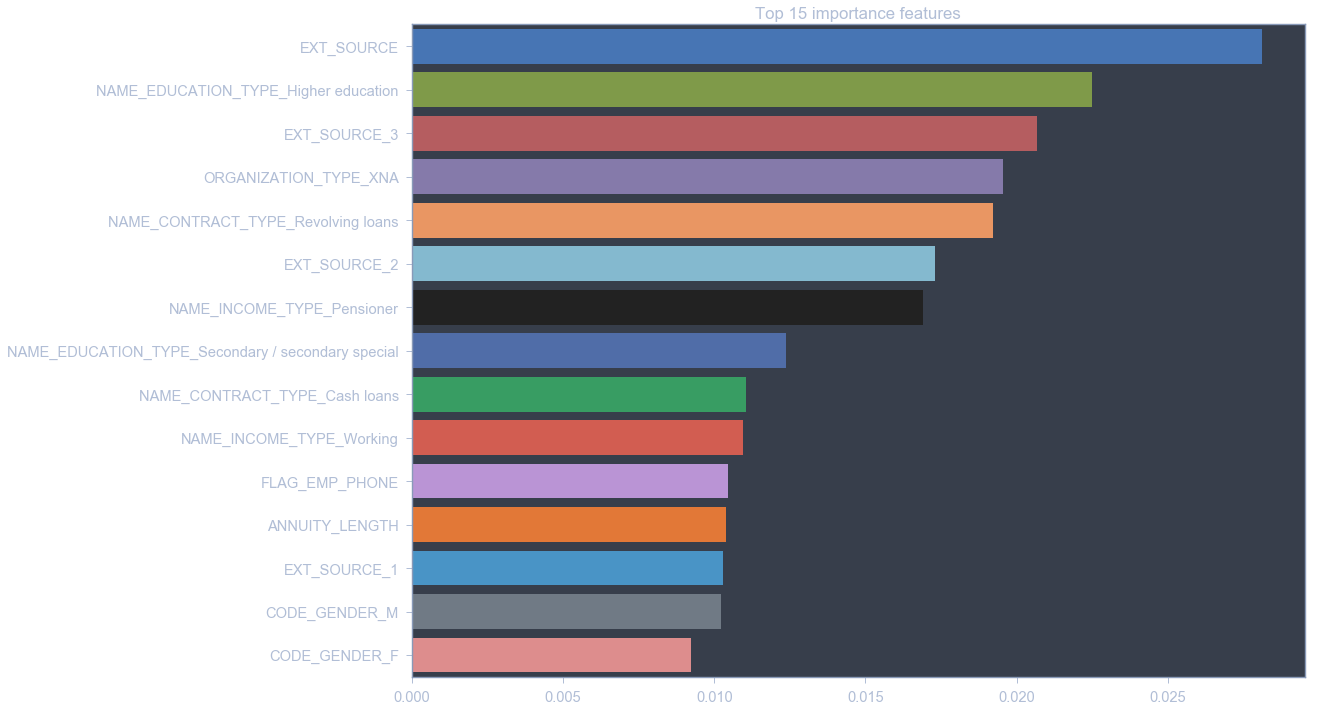

In [17]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.02, n_estimators = 1500,
                              max_depth = 5, min_child_weight = 4,
                              subsample = 0.8, colsample_bytree = 0.3,
                              objective = 'binary:logistic', reg_alpha = 1.25,
                              random_state = 42)
#fit
xgb_model.fit(data_train, target)
importance, feature = (list(x) for x in zip(*sorted(zip(xgb_model.feature_importances_,
                                                        features), reverse = True)))

plt.figure(figsize = (16, 12))
sns.barplot(importance[:15], feature[:15])
plt.title('Top 15 importance features')
plt.show()

# Predict submission

In [18]:
predict = xgb_model.predict_proba(data_test)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR' : ID['SK_ID_CURR'], 'TARGET' : predict})
submission.head(5)

,SK_ID_CURR,TARGET
0,100001,0.043154
1,100005,0.088618
2,100013,0.010860
3,100028,0.032551
4,100038,0.154244


In [19]:
submission.to_csv('Kaggle Home Credit Default.csv', index = False)